In [1]:
import boto3
import botocore
import sagemaker
import sys


bucket = 'test-sagemaker-10-28-2019'   # <--- specify a bucket you have access to
prefix = 'sagemaker/rcf-benchmarks'
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://test-sagemaker-10-28-2019/sagemaker/rcf-benchmarks


In [2]:

%%time

import pandas as pd
import urllib.request

data_filename = 'nyc_taxi.csv'
data_source = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'

urllib.request.urlretrieve(data_source, data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=',')

CPU times: user 26.6 ms, sys: 5.02 ms, total: 31.7 ms
Wall time: 171 ms


In [3]:
taxi_data.head(25)


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
5,2014-07-01 02:30:00,2873
6,2014-07-01 03:00:00,2369
7,2014-07-01 03:30:00,2064
8,2014-07-01 04:00:00,2221
9,2014-07-01 04:30:00,2158


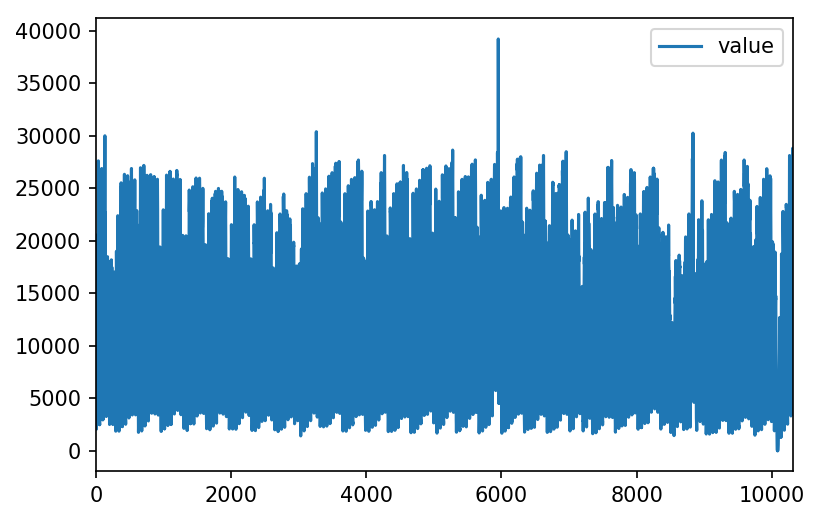

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas
matplotlib.rcParams['figure.dpi'] = 150

taxi_data.plot()

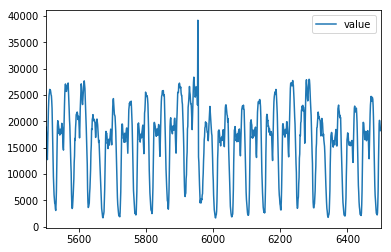

In [5]:
taxi_data[5500:6500].plot()

In [7]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data.value.as_matrix().reshape(-1,1)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


2019-10-31 18:13:44 Starting - Starting the training job...
2019-10-31 18:13:47 Starting - Launching requested ML instances......
2019-10-31 18:14:49 Starting - Preparing the instances for training......
2019-10-31 18:15:52 Downloading - Downloading input data...
2019-10-31 18:16:33 Training - Downloading the training image..Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[10/31/2019 18:16:55 INFO 139987605206848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ft

In [8]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2019-10-31-18-13-44-748


In [9]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

---------------------------------------------------------------------------------------------------!

In [ ]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

In [10]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [11]:
taxi_data_numpy = taxi_data.value.as_matrix().reshape(-1,1)
print(taxi_data_numpy[:6])
results = rcf_inference.predict(taxi_data_numpy[:6])

[[10844]
 [ 8127]
 [ 6210]
 [ 4656]
 [ 3820]
 [ 2873]]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [ ]:
print(results)

In [12]:
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to taxi data frame and print first few values
taxi_data['score'] = pd.Series(scores, index=taxi_data.index)
taxi_data.head()

,timestamp,value,score
0,2014-07-01 00:00:00,10844,0.934224
1,2014-07-01 00:30:00,8127,0.979351
2,2014-07-01 01:00:00,6210,0.943516
3,2014-07-01 01:30:00,4656,0.886642
4,2014-07-01 02:00:00,3820,0.882162


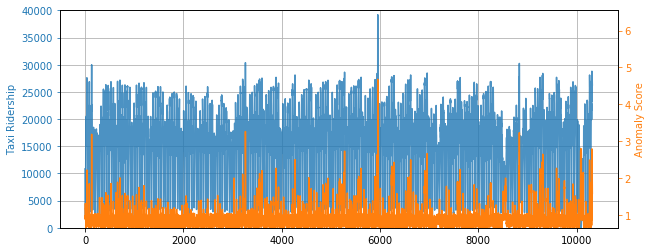

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
#start, end = 5500, 6500
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset['value'], color='C0', alpha=0.8)
ax2.plot(taxi_data_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [14]:

score_mean = taxi_data['score'].mean()
score_std = taxi_data['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = taxi_data_subset[taxi_data_subset['score'] > score_cutoff]
anomalies

,timestamp,value,score
37,2014-07-01 18:30:00,27598,2.217880
38,2014-07-01 19:00:00,26827,1.834420
87,2014-07-02 19:30:00,26872,1.846613
134,2014-07-03 19:00:00,29985,3.187651
527,2014-07-11 23:30:00,26873,1.851037
661,2014-07-14 18:30:00,26945,1.886792
710,2014-07-15 19:00:00,27167,2.004838
1094,2014-07-23 19:00:00,26528,1.724860
1098,2014-07-23 21:00:00,26600,1.746099
1198,2014-07-25 23:00:00,26688,1.794187


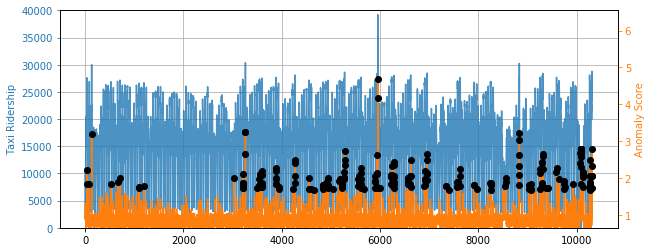

In [15]:
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

In [17]:

sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:201213785792:endpoint/randomcutforest-2019-10-31-18-13-44-748".